# [darts](https://github.com/unit8co/darts) Experiments and Tests

In [1]:
import sys
import pandas as pd
import numpy as np
import sqlite3
import time

import logzero
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
from darts import TimeSeries, models, metrics, backtesting
from darts.utils import statistics, missing_values

from marketml.data.stocks import StockPreprocessor

[I 200715 18:02:00 __init__:15] Project directory: /Users/taras/Code/projects/MarketML


In [11]:
pd.options.plotting.backend = "plotly"
logger = logzero.setup_logger("darts")
ticker = "AAPL", "AMZN"]

In [18]:
data = {}
start = time.perf_counter()
preprocessor = StockPreprocessor()
preprocessor(ticker)
df = preprocessor.process(split=False)
logger.debug(f"{ticker} DataFrame: {time.perf_counter() - start} | {len(df)}")

start = time.perf_counter()
ts = TimeSeries.from_dataframe(df, time_col=None, value_cols=["adjusted_close"], freq="B")
logger.debug(f"{ticker} TimeSeries: {time.perf_counter() - start} | {len(ts)}")

data[ticker] = ts

[D 200715 18:13:24 <ipython-input-18-98439ef7eeaa>:7] AAPL DataFrame: 0.7348995819997981 | 5031
[D 200715 18:13:24 <ipython-input-18-98439ef7eeaa>:11] AAPL TimeSeries: 0.34187668000004123 | 5218
[D 200715 18:13:25 <ipython-input-18-98439ef7eeaa>:7] AMZN DataFrame: 0.5386370230003195 | 5031
[D 200715 18:13:25 <ipython-input-18-98439ef7eeaa>:11] AMZN TimeSeries: 0.39537414500000523 | 5218


In [19]:
for ticker, ts in data.items():
    start = time.perf_counter()
    train, validation = ts.split_before(pd.Timestamp('20190101'))
    train, validation = missing_values.auto_fillna(train), missing_values.auto_fillna(validation)
    data[ticker] = {"train": train, "validation": validation}
    logger.debug(f"{ticker}: {time.perf_counter() - start}")

[D 200715 18:13:25 <ipython-input-19-1d4540ef8425>:6] AAPL: 0.05454605300019466
[D 200715 18:13:25 <ipython-input-19-1d4540ef8425>:6] AMZN: 0.06647940099992411


In [22]:
for ticker, series in data.items():
    for use, ts in series.items():
        plot = ts.pd_dataframe().plot()
        plot.show()

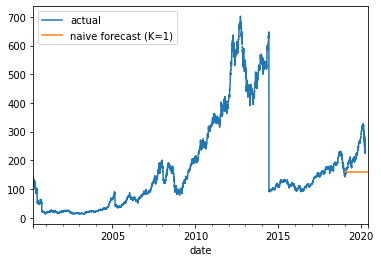

In [18]:
for ticker, datasets in data.items():
    naive_model = NaiveSeasonal(K=1)
    naive_model.fit(datasets["train"])
    naive_forecast = naive_model.predict(90)
    fig = {"data": [{"x": datasets}]}
series.plot(label='actual')
naive_forecast.plot(label='naive forecast (K=1)')
plt.legend();

It's very easy to fit models and produce predictions on `TimeSeries`. All the models have a `fit()` and a `predict()` function. This is similar to [https://scikit-learn.org/](https://scikit-learn.org/), except that it is specific to time series. The `fit()` function takes in argument the training time series on which to fit the model, and the `predict()` function takes in argument the number of time steps (after the end of the training series) over which to forecast.

### Inspect Seasonality
Our model above is perhaps a bit too naive. We can already improve by exploiting the seasonality in the data. It seems quite obvious that the data has a yearly seasonality, which we can confirm by looking at the auto-correlation function (ACF), and highlighting the lag `m=12`:

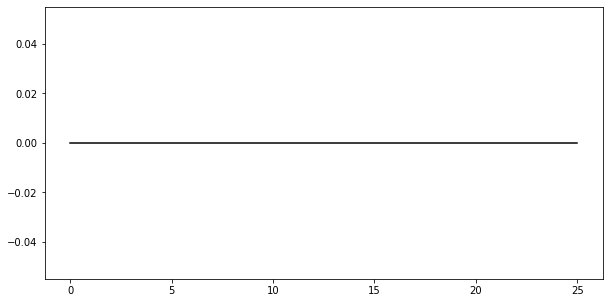

In [21]:
plot_acf(train, alpha = .2)

The ACF presents a spike at x = 12, which suggests a yearly seasonality trend (highlighted in red). The blue zone determines the significance of the statistics for a confidence level of alpha = 5%. In cases where we are unsure, we can also run a statistical check of seasonality for each candidate period `m`:

In [23]:
for m in range(2, 25):
    is_seasonal, period = check_seasonality(train, m=m, alpha=.05)
    if is_seasonal:
        print('There is seasonality of order {}.'.format(period))

### A less naive model
Let's try the `NaiveSeasonal` model again with a seasonality of 12:

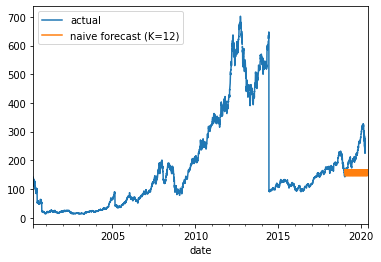

In [25]:
seasonal_model = NaiveSeasonal(K=12)
seasonal_model.fit(train)
seasonal_forecast = seasonal_model.predict(365)

series.plot(label='actual')
seasonal_forecast.plot(label='naive forecast (K=12)')
plt.legend();

This is better, but we are still missing the trend. Fortunately, there is also another naive baseline model capturing the trend, which is called `NaiveDrift`. This model will simply produce linear predictions, with a slope that is determined by the first and last values of the training set:

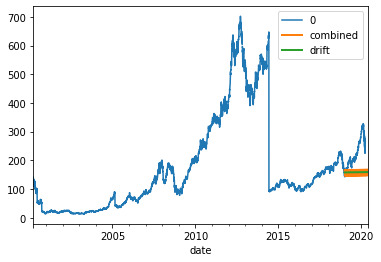

In [26]:
drift_model = NaiveDrift()
drift_model.fit(train)
drift_forecast = drift_model.predict(365)

combined_forecast = drift_forecast + seasonal_forecast - train.last_value()

series.plot()
combined_forecast.plot(lw=2, label='combined')
drift_forecast.plot(lw=2, label='drift')
plt.legend();

What happened in the last cell? We simply fit a naive drift model, and add its forecast to the seasonal forecast we had previously. We also substract the last value of the training set to the result, so that the resulting combined forecast starts off with the right offset.

This looks already like a fairly descent forecast, and we did not use any non-naive model yet! In fact - any model should be able to beat this. But hey, what's the error we are getting here? Let's see what we'll have to beat:

In [27]:
print("Mean absolute percentage error for the combined naive drift + seasonal: {:.2f}%.".format(
      mape(series, combined_forecast)))

Mean absolute percentage error for the combined naive drift + seasonal: nan%.


## Quickly try a few more models
`darts` is built to make it easy to train and validate several models in a unified way. Let's train a few more and compute their respective MAPE on the validation set:

In [25]:
def eval_model(model):
    model.fit(train)
    forecast = model.predict(len(val))
    print('model {} obtains MAPE: {:.2f}%'.format(model, mape(val, forecast)))

eval_model(ExponentialSmoothing())
eval_model(Prophet())
eval_model(AutoARIMA())
eval_model(Theta())

model Exponential smoothing obtains MAPE: 2.12%
model Prophet obtains MAPE: 1.73%
model Auto-ARIMA obtains MAPE: 1.69%
model Theta(0) obtains MAPE: 1.69%


Here, we did only built these models with their default parameters. We can probably do better if we fine-tune to our problem. Let's try with the Theta method.

## The Theta method

The model `Theta` contains an implementation of Assimakopoulos and Nikolopoulos' Theta method. This method has known great success, particularly in the M3-competition.

Though the value of the Theta parameter is often set to 0 in applications, our implementation supports a variable value for parameter tuning purposes. Let's try to find a good value for Theta:

In [26]:
# Search for the best theta parameter, by trying 50 different values
thetas = np.linspace(-10, 10, 50)

best_mape = float('inf')
best_theta = 0

for theta in thetas:
    model = Theta(theta)
    model.fit(train)
    pred_theta = model.predict(len(val))
    res = mape(val, pred_theta)
    
    if res < best_mape:
        best_mape = res
        best_theta = theta

In [27]:
best_theta_model = Theta(best_theta)
best_theta_model.fit(train)
pred_best_theta = best_theta_model.predict(len(val))

print('The MAPE is: {:.2f}, with theta = {}.'.format(mape(val, pred_best_theta), best_theta))

The MAPE is: 1.69, with theta = 2.2448979591836746.


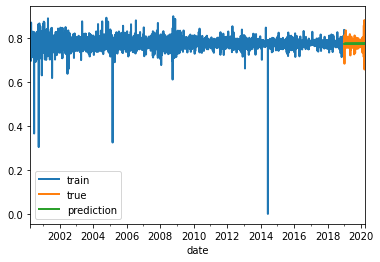

In [28]:
train.plot(lw=2, label='train')
val.plot(lw=2, label='true')
pred_best_theta.plot(lw=2, label='prediction')
plt.legend();

We can observe that the model with `best_theta` is so far the best we have, in terms of MAPE.

## Backtesting: simulate historical forecasting
So at this point we have a model that performs well on our validation set, and that's good. But how can we know the performance we *would have obtained* if we *had been using this model* historically. 

Backtesting simulates predictions that would have been obtained historically with a given model. It can take a while to produce, since the model is re-fit every time the simulated prediction time advances.

Such simulated forecasts are always defined with respect to a *forecast horizon*, which is the number of time steps that separate the prediction time from the forecast time. In the example below, we simulate forecasts done for 3 months in the future (compared to prediction time).

In [29]:
best_theta_model = Theta(best_theta)

historical_fcast_theta = backtest_forecasting(series, best_theta_model, pd.Timestamp('20020101'), 
                                              fcast_horizon_n=770, verbose=True)

ValueError: The provided start timestamp is not in the time series.

Let's see what this backtest forecast looks like. You can see it produces more accurate predictions than the one-off prediction done above, because here the model is re-fit every month.

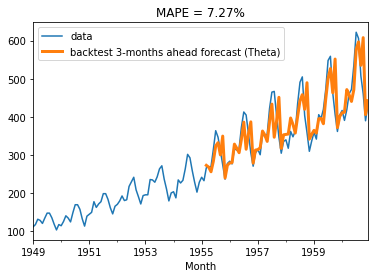

In [15]:
series.plot(label='data')
historical_fcast_theta.plot(lw=3, label='backtest 3-months ahead forecast (Theta)')
plt.title('MAPE = {:.2f}%'.format(mape(historical_fcast_theta, series)))
plt.legend();

Let's look at the fitted value residuals of our current `Theta` model, i.e. the difference between the 1-step forecasts at every point in time obtained by fitting the model on all previous points, and the actual observed values.

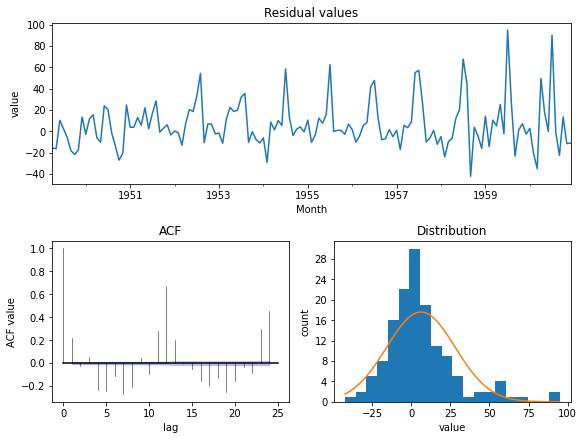

In [16]:
plot_residuals_analysis(forecasting_residuals(best_theta_model, series))

We can see that the distribution has a mean that is slightly larger than 0. This means that our `Theta` model is biased. We can also make out a large ACF value at lag equal to 12, which indicates that the residuals contain information that was not used by the model.

Could we maybe do better with a simple `ExponentialSmoothing` model?

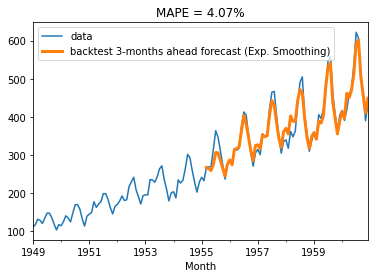

In [17]:
model_es = ExponentialSmoothing()
historical_fcast_es = backtest_forecasting(series, model_es, pd.Timestamp('19550101'), 
                                           fcast_horizon_n=3, verbose=True)
series.plot(label='data')
historical_fcast_es.plot(lw=3, label='backtest 3-months ahead forecast (Exp. Smoothing)')
plt.title('MAPE = {:.2f}%'.format(mape(historical_fcast_es, series)))
plt.legend()

This much better! We get a mean absolute percentage error of 4.08% when backtesting with a 3-months forecast horizon in this case. 

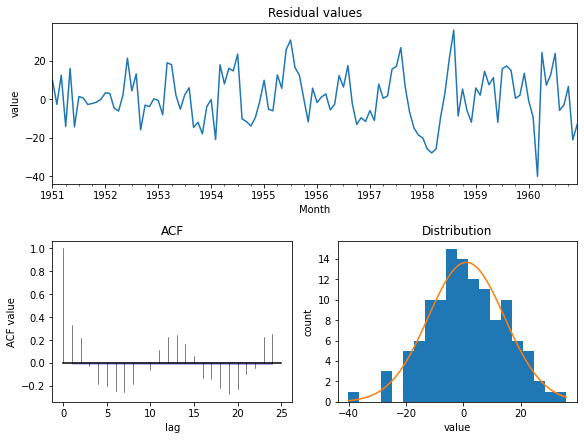

In [18]:
plot_residuals_analysis(forecasting_residuals(model_es, series))

The residual analysis also reflects an improved performance in that we now have a distribution of the residuals centred at value 0, and the ACF values, although not insignificant, have lower magnitudes.

## Ensembling several predictions
*Ensembling* is about combining the forecasts produced by several models, in order to obtain a final -- and hopefully better forecast.

For instance, in our example of a "less naive" model above, we manually combined a naive seasonal model with a naive drift model. Here, we will try to find such combinations in an automated way, using `RegressionModel`s. A regression model is a model that predicts a *target* time series from a bunch of *features* time series. If the features time series are themselves obtained from forecasting models, their future (predicted) values can be combined using the regression model to obtain a final forecast.

Here, we will first compute the historical predictions two naive seasonal models (with 6 and 12 months seasonality), and naive drift model. To compute the historical predictions, we can simply reuse the `backtest_forecasting()` method:

In [19]:
models = [NaiveSeasonal(6), NaiveSeasonal(12), NaiveDrift()]

model_predictions = [backtest_forecasting(series, m, pd.Timestamp('19570101'), fcast_horizon_n=6, verbose=True)
                     for m in models]

Now that we have the historical forecasts *that we would have obtained* from a couple of models, we can train a `StandardRegressionModel`, in order to learn in a supervised way how to best combine the features time series (our 3 forecasts) into the target series that we are trying to predict.

By default the `StandardRegressionModel` will fit a linear regression for predicting the target series from some features series. If you want something different than linear regression, `StandardRegressionModel` can wrap around any scikit-learn regression model.

In [20]:
""" We build the regression model, and tell it to use the 12 preceding points to fit the regression
"""
regr_model = StandardRegressionModel(train_n_points=12)

""" Our target series is what we want to predict (the actual data)
    It has to have the same time index as the features series:
"""
series_target = series.slice_intersect(model_predictions[0])

""" Here we backtest our regression model
"""
ensemble_pred = backtest_regression(model_predictions, series_target, regr_model, 
                                    pd.Timestamp('19580101'), fcast_horizon_n=3, verbose=True)

Finally, let's see how good the regression performs, compared to the original forecasts:

MAPE Error for Naive seasonal model, with K=6: 21.54%
MAPE Error for Naive seasonal model, with K=12: 8.36%
MAPE Error for Naive drift model: 21.92%
MAPE Error ensemble: 5.65%

Coefficients of the features time series:
Learned coefficient for Naive seasonal model, with K=6: 7.64
Learned coefficient for Naive seasonal model, with K=12: 1.02
Learned coefficient for Naive drift model: -7.28


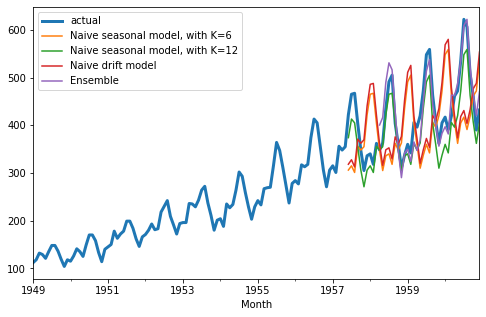

In [21]:
plt.figure(figsize=(8,5))

series.plot(lw=3, label='actual')
for i, m in enumerate(models):
    model_predictions[i].plot(label=str(m))
    
    # intersect last part, to compare all the methods over the duration of the ensemble forecast
    model_pred = model_predictions[i].slice_intersect(ensemble_pred)
       
    mape_model = mape(series, model_pred)
    print('MAPE Error for {}: {:.2f}%'.format(m, mape_model))

print('MAPE Error ensemble: {:.2f}%'.format(mape(series, ensemble_pred)))

ensemble_pred.plot(label='Ensemble')

print('\nCoefficients of the features time series:')
for i, m in enumerate(models):
    print('Learned coefficient for {}: {:.2f}'.format(m, regr_model.model.coef_[0][i]))
plt.legend();

That's quite nice: by just combining 3 naive models (two seasonal repetitions and a linear trend) using a linear regression, we get a decent-looking ensemble model, which is better than any of the sub-model, with a MAPE of 5.65%.

A couple of interesting things to observe:
* Note how the seasonal model for `K=6` and the naive drift model have an incorrect phase compared to the original signal (due to the original signal having a true seasonality of 12). Despite this, the ensembling is able to learn coefficients that compensate for this effect. Removing either of the two models results in worse performance.
* Note how the regression (ensemble) forecast starts off 12 months after the individual models forecasts -- that is because the regression model needs 12 data points to fit the weights coefficients of the linear regression.

## FFT and RNNs
If you'd like to try models based on Fast Fourier Transform or Recurrent Neural Networks, we recommend that you go over the `FFT-examples.ipynb` and `RNN-examples.ipynb` notebooks, respectively.

## A final word of caution
So is Theta, exponential smoothing, or a linear regression of naive models the best approach for predicting the future number of airline passengers? Well, at this point it's still hard to say exactly which one is best. Our time series is small, and our validation set is even smaller. In such cases, it's very easy to overfit the whole forecasting exercise to such a small validation set. That's especially true if the number of available models and their degrees of freedom is high; so always take results with a grain of salt (especially on small datasets), and apply the scientific method before making any kind of forecast!